In [2]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

unable to import 'smart_open.gcs', disabling that module


In [3]:
len(model.vocab)

3000000

# 70. 単語ベクトルの和による特徴量

In [4]:
import numpy as np
import re
from functools import reduce
from nltk.tokenize import word_tokenize
#from nltk.stem.porter import PorterStemmer

In [5]:
def load_data(dir_name, file_name):
    with open(f'{dir_name}{file_name}') as f:
        X = list()
        Y = list()
        for line in f:
            line = line.strip()
            splited_line = line.split('\t')
            X.append(splited_line[0])
            Y.append(splited_line[1])
        return np.asarray(X), np.asarray(Y)

def txt2vec(x):
    vec_x_list = list()
    for text in x:
        words = word_tokenize(text)
        words_vec = [model[word] for word in words if word in model]
        if not words_vec:
            print(words)
            continue
        vec_x_list.append(sum(words_vec) / len(words_vec))
    return np.asarray(vec_x_list)

def save_file_npy(dir_name, file_name, x):
    np.save(f'{dir_name}{file_name}', x)
        
def load_file_npy(dir_name, file_name):
    return np.load(f'{dir_name}{file_name}')

def chr2num(y):
    converter = {'b':0, 't':1, 'e':2, 'm':3}
    return np.asarray([converter[article_type] for article_type in y])

In [26]:
train_x, train_y = load_data('data/', 'train.txt')
valid_x, valid_y = load_data('data/', 'valid.txt')
test_x, test_y = load_data('data/', 'test.txt')

In [27]:
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

(10680,) (10680,)
(1335,) (1335,)
(1335,) (1335,)


In [28]:
train_x = txt2vec(train_x)
valid_x = txt2vec(valid_x)
test_x = txt2vec(test_x)

In [304]:
train_y = chr2num(train_y)
valid_y = chr2num(valid_y)
test_y = chr2num(test_y)

In [305]:
save_file_npy('work/', 'train_x', train_x)
save_file_npy('work/', 'train_y', train_y)
save_file_npy('work/', 'valid_x', valid_x)
save_file_npy('work/', 'valid_y', valid_y)
save_file_npy('work/', 'test_x', test_x)
save_file_npy('work/', 'test_y', test_y)

# 71. 単層ニューラルネットワークによる予測

In [6]:
train_x = load_file_npy('work/', 'train_x.npy')
train_y = load_file_npy('work/', 'train_y.npy')
valid_x = load_file_npy('work/', 'valid_x.npy')
valid_y = load_file_npy('work/', 'valid_y.npy')
test_x = load_file_npy('work/', 'test_x.npy')
test_y = load_file_npy('work/', 'test_y.npy')

In [7]:
print(train_x.shape, train_y.shape)

(10680, 300) (10680,)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch.autograd import Variable

In [60]:
torch.manual_seed(3)
W = torch.randn(300, 4)
print(W)

tensor([[-0.0766,  0.3599, -0.7820,  0.0715],
        [ 0.6648, -0.2868,  1.6206, -1.5967],
        [-0.0517, -0.3060,  0.2485, -0.2226],
        ...,
        [ 0.2647, -0.8119, -0.9138,  0.1027],
        [-0.7688, -1.7742, -1.8339,  0.5013],
        [ 0.6518, -0.1978,  0.7931, -1.5037]])


In [61]:
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

In [62]:
print(F.softmax(torch.matmul(train_x[:1], W), dim=1))

tensor([[0.2599, 0.1483, 0.5256, 0.0662]])


In [63]:
print(F.softmax(torch.matmul(train_x[:4], W), dim=1))

tensor([[0.2599, 0.1483, 0.5256, 0.0662],
        [0.0845, 0.0077, 0.8012, 0.1066],
        [0.1564, 0.0854, 0.7054, 0.0527],
        [0.0561, 0.0441, 0.7722, 0.1276]])


# 72. 損失と勾配の計算

In [426]:
torch.manual_seed(0)
W = nn.Parameter(torch.randn(300, 4), requires_grad=True)
print(W)

Parameter containing:
tensor([[-1.1258, -1.1524, -0.2506, -0.4339],
        [ 0.8487,  0.6920, -0.3160, -2.1152],
        [ 0.3223, -1.2633,  0.3500,  0.3081],
        ...,
        [ 1.1469, -0.1733,  0.0637, -1.2699],
        [-0.6212, -0.2381,  0.0892,  1.8008],
        [-2.0627,  0.3222, -1.1390,  1.2418]], requires_grad=True)


In [427]:
criterion = nn.CrossEntropyLoss()
v_train_x = train_x[:4]
v_train_y = train_y[:4]

In [428]:
print(v_train_x)

tensor([[ 0.0170, -0.0622, -0.0194,  ..., -0.0100,  0.1557, -0.0435],
        [-0.0488,  0.0571,  0.1176,  ...,  0.0959,  0.1008,  0.0121],
        [ 0.0923,  0.0072, -0.2906,  ...,  0.0138,  0.0388, -0.0379],
        [ 0.0472, -0.0069, -0.0391,  ..., -0.0337,  0.0504, -0.1157]])


In [429]:
v_train_x = torch.matmul(v_train_x, W)
loss = criterion(v_train_x, v_train_y)

In [430]:
print(loss)

tensor(3.4065, grad_fn=<NllLossBackward>)


In [431]:
loss.backward()
print(W.grad)

tensor([[ 0.0115,  0.0194, -0.0339,  0.0029],
        [-0.0103, -0.0047, -0.0004,  0.0154],
        [-0.0262, -0.0441,  0.0811, -0.0108],
        ...,
        [-0.0178,  0.0115,  0.0053,  0.0010],
        [-0.0151,  0.0673, -0.0184, -0.0338],
        [-0.0068, -0.0309,  0.0360,  0.0017]])


In [432]:
torch.manual_seed(0)
W = nn.Parameter(torch.randn(300, 4), requires_grad=True)
print(W)

Parameter containing:
tensor([[-1.1258, -1.1524, -0.2506, -0.4339],
        [ 0.8487,  0.6920, -0.3160, -2.1152],
        [ 0.3223, -1.2633,  0.3500,  0.3081],
        ...,
        [ 1.1469, -0.1733,  0.0637, -1.2699],
        [-0.6212, -0.2381,  0.0892,  1.8008],
        [-2.0627,  0.3222, -1.1390,  1.2418]], requires_grad=True)


In [433]:
out = torch.matmul(train_x[:1], W)
loss = criterion(out, train_y[:1])

In [434]:
print(loss)

tensor(5.8259, grad_fn=<NllLossBackward>)


In [435]:
loss.backward()
print(W.grad)

tensor([[ 1.2397e-04,  1.5989e-02,  8.5838e-04, -1.6971e-02],
        [-4.5319e-04, -5.8451e-02, -3.1380e-03,  6.2042e-02],
        [-1.4114e-04, -1.8203e-02, -9.7726e-04,  1.9321e-02],
        ...,
        [-7.3013e-05, -9.4169e-03, -5.0556e-04,  9.9955e-03],
        [ 1.1338e-03,  1.4623e-01,  7.8504e-03, -1.5521e-01],
        [-3.1683e-04, -4.0864e-02, -2.1938e-03,  4.3374e-02]])


# 73. 確率的勾配降下法による学習

In [9]:
import tqdm

In [10]:
train_x = load_file_npy('work/', 'train_x.npy')
train_y = load_file_npy('work/', 'train_y.npy')
valid_x = load_file_npy('work/', 'valid_x.npy')
valid_y = load_file_npy('work/', 'valid_y.npy')
test_x = load_file_npy('work/', 'test_x.npy')
test_y = load_file_npy('work/', 'test_y.npy')

In [8]:
torch.manual_seed(0)
W = nn.Parameter(torch.randn(300, 4), requires_grad=True)
print(W)

Parameter containing:
tensor([[-1.1258, -1.1524, -0.2506, -0.4339],
        [ 0.8487,  0.6920, -0.3160, -2.1152],
        [ 0.3223, -1.2633,  0.3500,  0.3081],
        ...,
        [ 1.1469, -0.1733,  0.0637, -1.2699],
        [-0.6212, -0.2381,  0.0892,  1.8008],
        [-2.0627,  0.3222, -1.1390,  1.2418]], requires_grad=True)


In [9]:
def train(train_x, train_y, op, criterion, W, batch_size=4, nepoch=100):
    ntrain = len(train_x)
    loss_list = list()
    for epoch in tqdm.notebook.tqdm(range(nepoch)):
        sum_loss = 0
        perm = np.random.permutation(ntrain)
        for i in range(0, ntrain, batch_size):
            batch_x = torch.from_numpy(train_x[perm[i:i + batch_size]])
            batch_y = torch.from_numpy(train_y[perm[i:i + batch_size]])
            batch_x = torch.matmul(batch_x, W)
            loss = criterion(batch_x, batch_y)
            op.zero_grad()
            loss.backward()
            op.step()
            sum_loss += loss.data.item() * len(batch_x)
        loss_list.append(sum_loss / ntrain)
    return loss_list

In [10]:
ntrain = len(train_x)
nepoch = 100
op = optim.SGD([W], lr=0.01)
criterion = nn.CrossEntropyLoss()
result = train(train_x, train_y, op, criterion, W, batch_size=1)

In [11]:
print(W)

Parameter containing:
tensor([[-2.0084, -0.0870,  0.4193, -1.2856],
        [ 0.4284,  0.9958, -0.1726, -2.1407],
        [ 0.7639,  0.6409, -2.3561,  0.6676],
        ...,
        [ 0.4443, -0.0269, -0.8825,  0.2330],
        [ 1.7208, -1.4965, -0.3150,  1.1232],
        [-2.2433, -1.0501, -0.5166,  2.1715]], requires_grad=True)


In [12]:
print(result[::10])

[0.9254317359959309, 0.34149034377692755, 0.2993721159433582, 0.27968309584805706, 0.267745152095906, 0.2595121769816251, 0.25359422520635694, 0.2488213407094142, 0.2454812020850184, 0.24248561884453057]


In [49]:
! ./src/a.out

epoch0: 0.687041
epoch1: 0.476448
epoch2: 0.415567
epoch3: 0.383298
epoch4: 0.362784
epoch5: 0.348309
epoch6: 0.337385
epoch7: 0.328745
epoch8: 0.321681
epoch9: 0.315753
epoch10: 0.310678
epoch11: 0.30626
epoch12: 0.302367
epoch13: 0.298898
epoch14: 0.295775
epoch15: 0.292946
epoch16: 0.290362
epoch17: 0.28799
epoch18: 0.285801
epoch19: 0.28377
epoch20: 0.281879
epoch21: 0.280112
epoch22: 0.278455
epoch23: 0.276896
epoch24: 0.275428
epoch25: 0.27404
epoch26: 0.272726
epoch27: 0.271478
epoch28: 0.270291
epoch29: 0.269161
epoch30: 0.268083
epoch31: 0.267052
epoch32: 0.266066
epoch33: 0.265122
epoch34: 0.264216
epoch35: 0.263347
epoch36: 0.262511
epoch37: 0.261705
epoch38: 0.26093
epoch39: 0.260184
epoch40: 0.259463
epoch41: 0.258766
epoch42: 0.258094
epoch43: 0.257442
epoch44: 0.256813
epoch45: 0.256203
epoch46: 0.255612
epoch47: 0.25504
epoch48: 0.254484
epoch49: 0.253945
epoch50: 0.253421
epoch51: 0.252912
epoch52: 0.252417
epoch53: 0.251935
epoch54: 0.251465
epoch55: 0.251009
epoch56:

# 74. 正解率の計測

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
def calc_acc(data_x, data_y, W):
    with torch.no_grad():
        pred_y = torch.argmax(torch.matmul(torch.from_numpy(data_x), W), dim=1)
    return accuracy_score(data_y, pred_y)

In [15]:
print(f'test_acc={calc_acc(test_x, test_y, W)}')

test_acc=0.9071161048689138


In [16]:
print(f'train_loss={calc_acc(train_x, train_y, W)}')

train_loss=0.9185393258426966


# 75. 損失と正解率のプロット

https://pytorch.org/docs/stable/tensorboard.html

In [13]:
from torch.utils.tensorboard import SummaryWriter
import tqdm

In [15]:
def execution(data_x, data_y, op, criterion, W, batch_size=4, is_train=True):
    ndata = len(data_x)
    perm = np.random.permutation(ndata)
    sum_loss = 0
    for i in range(0, ndata, batch_size):
        op.zero_grad()
        batch_x = torch.from_numpy(data_x[perm[i:i + batch_size]])
        batch_y = torch.from_numpy(data_y[perm[i:i + batch_size]])
        if is_train:
            out = torch.matmul(batch_x, W)
            loss = criterion(out, batch_y)
            loss.backward()
            op.step()
        else:
            with torch.no_grad():
                out = torch.matmul(batch_x, W)
                loss = criterion(out, batch_y)
        sum_loss += loss.data.item() * len(batch_x)
    return sum_loss / ndata

In [32]:
torch.manual_seed(0)
W = nn.Parameter(torch.randn(300, 4), requires_grad=True)
print(W)
ntrain = len(train_x)
nepoch = 100
op = optim.SGD([W], lr=0.01)
criterion = nn.CrossEntropyLoss()

Parameter containing:
tensor([[-1.1258, -1.1524, -0.2506, -0.4339],
        [ 0.8487,  0.6920, -0.3160, -2.1152],
        [ 0.3223, -1.2633,  0.3500,  0.3081],
        ...,
        [ 1.1469, -0.1733,  0.0637, -1.2699],
        [-0.6212, -0.2381,  0.0892,  1.8008],
        [-2.0627,  0.3222, -1.1390,  1.2418]], requires_grad=True)


In [33]:
train_writer = SummaryWriter(log_dir='./work/logs/train')
valid_writer = SummaryWriter(log_dir='./work/logs/valid')
for epoch in tqdm.notebook.tqdm(range(nepoch)):
    train_loss = execution(train_x, train_y, op, criterion, W, batch_size=1)
    train_writer.add_scalar("loss", train_loss, epoch) 
    train_writer.add_scalar("accuracy", calc_acc(train_x, train_y, W), epoch)
    
    valid_loss = execution(valid_x, valid_y, op, criterion, W, batch_size=1, is_train=False)
    valid_writer.add_scalar("loss", valid_loss, epoch)
    valid_writer.add_scalar("accuracy", calc_acc(valid_x, valid_y, W), epoch)
    
train_writer.close()
valid_writer.close()

In [40]:
from IPython.display import SVG

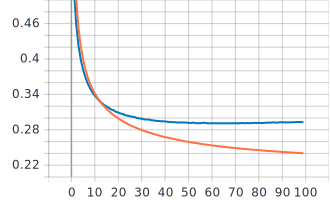

In [45]:
SVG("work/loss.svg")

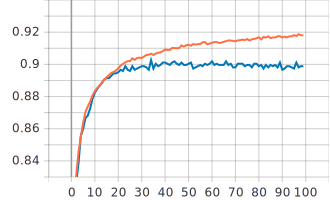

In [46]:
SVG("work/accuracy.svg")

# 76. チェックポイント

In [17]:
torch.manual_seed(0)
W = nn.Parameter(torch.randn(300, 4), requires_grad=True)
print(W)
ntrain = len(train_x)
nepoch = 10
op = optim.SGD([W], lr=0.01)
criterion = nn.CrossEntropyLoss()

Parameter containing:
tensor([[-1.1258, -1.1524, -0.2506, -0.4339],
        [ 0.8487,  0.6920, -0.3160, -2.1152],
        [ 0.3223, -1.2633,  0.3500,  0.3081],
        ...,
        [ 1.1469, -0.1733,  0.0637, -1.2699],
        [-0.6212, -0.2381,  0.0892,  1.8008],
        [-2.0627,  0.3222, -1.1390,  1.2418]], requires_grad=True)


In [18]:
for epoch in tqdm.notebook.tqdm(range(nepoch)):
    train_loss = execution(train_x, train_y, op, criterion, W, batch_size=1)
    valid_loss = execution(valid_x, valid_y, op, criterion, W, batch_size=1, is_train=False)
    torch.save({
        'epoch': epoch,
        'W': W,
        'optimizer_state_dict': op.state_dict(),
    }, f'./work/checkpoints/checkpoint_{epoch}.pt')

In [19]:
print(W)

Parameter containing:
tensor([[-1.8521, -0.5547,  0.3394, -0.8952],
        [ 0.8031,  0.7012, -0.3991, -1.9957],
        [ 0.0716, -0.3273, -0.9245,  0.8973],
        ...,
        [ 1.3952, -0.1296, -1.0046, -0.4936],
        [-0.1049, -0.8423, -0.0874,  2.0654],
        [-2.4062, -0.2060, -0.8290,  1.8035]], requires_grad=True)


In [21]:
torch.manual_seed(0)
W = nn.Parameter(torch.randn(300, 4), requires_grad=True)
checkpoint = torch.load('./work/checkpoints/checkpoint_9.pt')
op = optim.SGD([W], lr=0.01)
W = checkpoint['W']
op.load_state_dict(checkpoint['optimizer_state_dict'])

In [22]:
print(W)

Parameter containing:
tensor([[-1.8521, -0.5547,  0.3394, -0.8952],
        [ 0.8031,  0.7012, -0.3991, -1.9957],
        [ 0.0716, -0.3273, -0.9245,  0.8973],
        ...,
        [ 1.3952, -0.1296, -1.0046, -0.4936],
        [-0.1049, -0.8423, -0.0874,  2.0654],
        [-2.4062, -0.2060, -0.8290,  1.8035]], requires_grad=True)


# 77. ミニバッチ化

# 78. GPU上での学習

In [136]:
print(torch.cuda.is_available())

False


# 79. 多層ニューラルネットワーク

In [151]:
from torch.utils.tensorboard import SummaryWriter
import tqdm
from torch.utils.data import DataLoader
from collections import OrderedDict

In [155]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, num_hidden, hidden_dim, output_size, dropout):
        super(MLP, self).__init__()
        self.first_layer = nn.Linear(input_size, hidden_dim)
        self.hidden_layers = nn.Sequential(OrderedDict([
            (f'hidden_layer{i}', nn.Linear(hidden_dim, hidden_dim)) for i in range(num_hidden)
        ]))
        self.last_layer = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.first_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.dropout(self.relu(hidden_layer(x)))
        x = self.last_layer(x)
        x = self.softmax(x)
        return x

In [156]:
print(MLP(300, 3, 300, 4, 0.2))

MLP(
  (first_layer): Linear(in_features=300, out_features=300, bias=True)
  (hidden_layers): Sequential(
    (hidden_layer0): Linear(in_features=300, out_features=300, bias=True)
    (hidden_layer1): Linear(in_features=300, out_features=300, bias=True)
    (hidden_layer2): Linear(in_features=300, out_features=300, bias=True)
  )
  (last_layer): Linear(in_features=300, out_features=4, bias=True)
  (softmax): LogSoftmax()
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)


In [157]:
class MyDataSets(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [158]:
def execution(data_x, data_y, op, criterion, model, batch_size=1, is_train=True, use_gpu=False):
    if is_train: model.train()
    else: model.eval()
    ndata = len(data_x)
    dataset = MyDataSets(data_x, data_y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    sum_loss, acc_score = 0, 0
    for batch_x, batch_y in data_loader:
        if use_gpu:
            batch_x.cuda()
            batch_y.cuda()
        op.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        if is_train:
            loss.backward()
            op.step()
        sum_loss += loss.data.item() * len(batch_x)
        pred = torch.argmax(out, dim=1)
        acc_score += np.sum((pred == batch_y).cpu().detach().numpy())
    return sum_loss / ndata, acc_score / ndata * 100

In [176]:
#torch.manual_seed(0)
model = MLP(300, 3, 300, 4, 0.5)
ntrain = len(train_x)
nepoch = 100
op = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.NLLLoss()

    
logger = list()
for epoch in tqdm.notebook.tqdm(range(1, nepoch + 1)):
    train_loss, train_acc = execution(train_x, train_y, op, criterion, model, batch_size=256)
    with torch.no_grad():
        valid_loss, valid_acc = execution(valid_x, valid_y, op, criterion, model, batch_size=256, is_train=False)
    logger.append({'epoch':epoch, 'train_loss':train_loss, 'train_acc':train_acc, 'valid_loss':valid_loss, 'valid_acc':valid_acc})
    if epoch % 5 == 0:
        print({'epoch':epoch, 'train_loss':train_loss, 'train_acc':train_acc, 'valid_loss':valid_loss, 'valid_acc':valid_acc})
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer_state_dict': op.state_dict(),
        }, f'./work/checkpoints/checkpoint_{epoch}.pt')


{'epoch': 5, 'train_loss': 0.5253421511542931, 'train_acc': 79.05430711610487, 'valid_loss': 0.49559498837824617, 'valid_acc': 78.95131086142322}
{'epoch': 10, 'train_loss': 0.4219149863675293, 'train_acc': 83.73595505617978, 'valid_loss': 0.4115068948670719, 'valid_acc': 83.37078651685394}
{'epoch': 15, 'train_loss': 0.36295407133155994, 'train_acc': 86.23595505617978, 'valid_loss': 0.3737494556198406, 'valid_acc': 85.69288389513109}
{'epoch': 20, 'train_loss': 0.3279724585652798, 'train_acc': 88.88576779026216, 'valid_loss': 0.35227308969819143, 'valid_acc': 88.23970037453184}
{'epoch': 25, 'train_loss': 0.27843533531110387, 'train_acc': 90.83333333333333, 'valid_loss': 0.3318385514650452, 'valid_acc': 88.91385767790261}
{'epoch': 30, 'train_loss': 0.23980837913041705, 'train_acc': 92.38764044943821, 'valid_loss': 0.31610511165209926, 'valid_acc': 89.66292134831461}
{'epoch': 35, 'train_loss': 0.20354624445295513, 'train_acc': 93.78277153558052, 'valid_loss': 0.30821718475345367, 'va

In [177]:
model_100 = MLP(300, 3, 300, 4, 0.5)
checkpoint = torch.load('./work/checkpoints/checkpoint_100.pt')
model_100.load_state_dict(checkpoint['model'])
with torch.no_grad():
    _, test_acc = execution(test_x, test_y, op, criterion, model_199, batch_size=256, is_train=False)
    print(test_acc)

91.68539325842696
